In [79]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression



# import data

In [80]:
df = pd.read_excel('premiums_young.xlsx', index_col=0)
df.head()


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
9,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
10,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
16,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
19,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


In [81]:
df.shape

(20096, 13)

In [82]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20096 entries, 4 to 49998
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   age                    20096 non-null  int64 
 1   gender                 20096 non-null  object
 2   region                 20096 non-null  object
 3   marital_status         20096 non-null  object
 4   number_of_dependants   20096 non-null  int64 
 5   bmi_category           20096 non-null  object
 6   smoking_status         20094 non-null  object
 7   employment_status      20095 non-null  object
 8   income_level           20092 non-null  object
 9   income_lakhs           20096 non-null  int64 
 10  medical_history        20096 non-null  object
 11  insurance_plan         20096 non-null  object
 12  annual_premium_amount  20096 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 2.1+ MB


## Handle Na & duplicate values

In [84]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [85]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [86]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [87]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


In [88]:
df[df.number_of_dependants<0].shape

(22, 13)

In [89]:
df[df.number_of_dependants<0]['number_of_dependants'].unique()

array([-3, -1])

In [90]:
df.number_of_dependants = abs(df.number_of_dependants)

Finding Outliers 

In [91]:
numeric_col = df.select_dtypes(['float64', 'int64']).columns
numeric_col

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

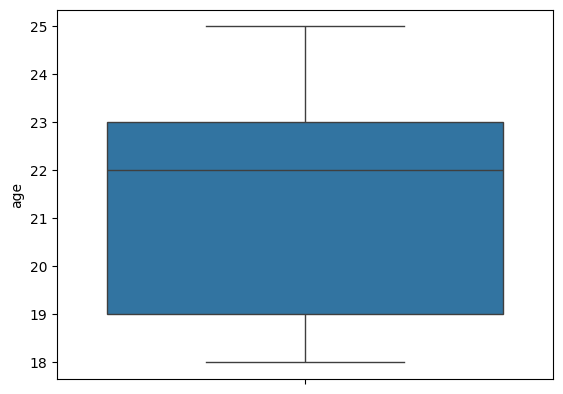

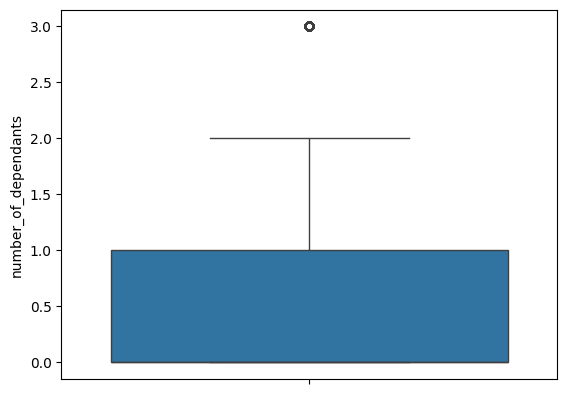

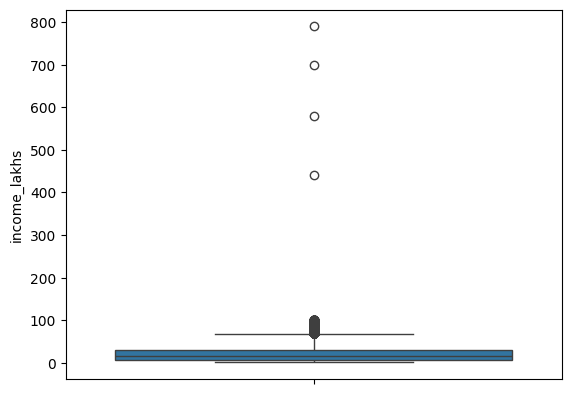

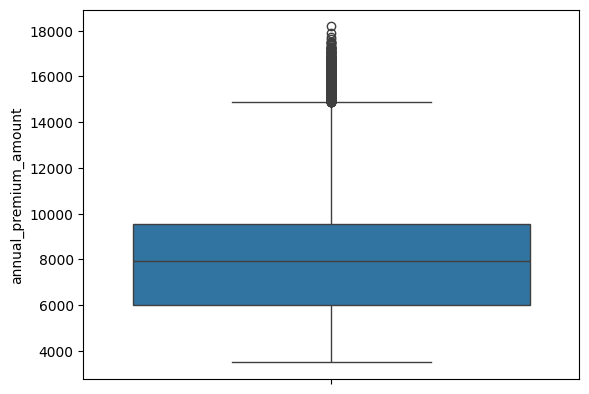

In [92]:
# fig, axes = plt.subplots(2, 2, figsize=(18, 8))  # Creates a 2x2 grid of subplots

for col in numeric_col :
    sns.boxplot(df[col])
    plt.show()



Ouliers in Age Colume

In [93]:
df[df.age>100].age.unique()

array([], dtype=int64)

In [94]:
df1 = df[df.age<=100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


Ouliers in Income_lakhs column

In [95]:
def get_iqr_bound(col):
    q1, q3 = col.quantile([0.25, 0.75])
    iqr = q3 - q1

    lower = q1 - 1.5*iqr
    higher = q3 + 1.5*iqr

    return lower, higher

In [96]:
get_iqr_bound(df.income_lakhs)

(-31.5, 68.5)

In [97]:
quantile_thresold = df.income_lakhs.quantile(0.999)
quantile_thresold

np.float64(100.0)

In [98]:
df1[df1['income_lakhs']>quantile_thresold].shape

(4, 13)

In [99]:
df2 = df1[df1['income_lakhs']<=quantile_thresold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263
std,2.294248,0.937238,21.732062,2749.912486
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.000000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,100.000000,18186.000000


## Visulaization distubution


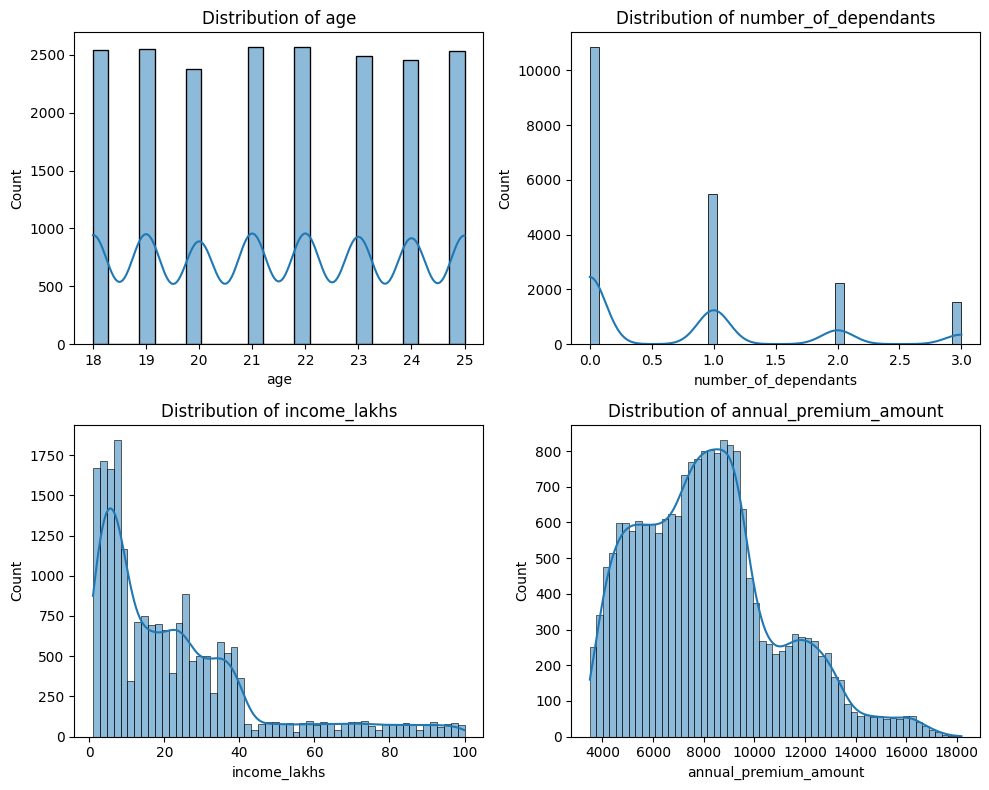

In [100]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Dynamic size based on column count

for i, col in enumerate(numeric_col):
    ax = axes[i//2, i%2]
    sns.histplot(df2[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')  # Adding title for clarity

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


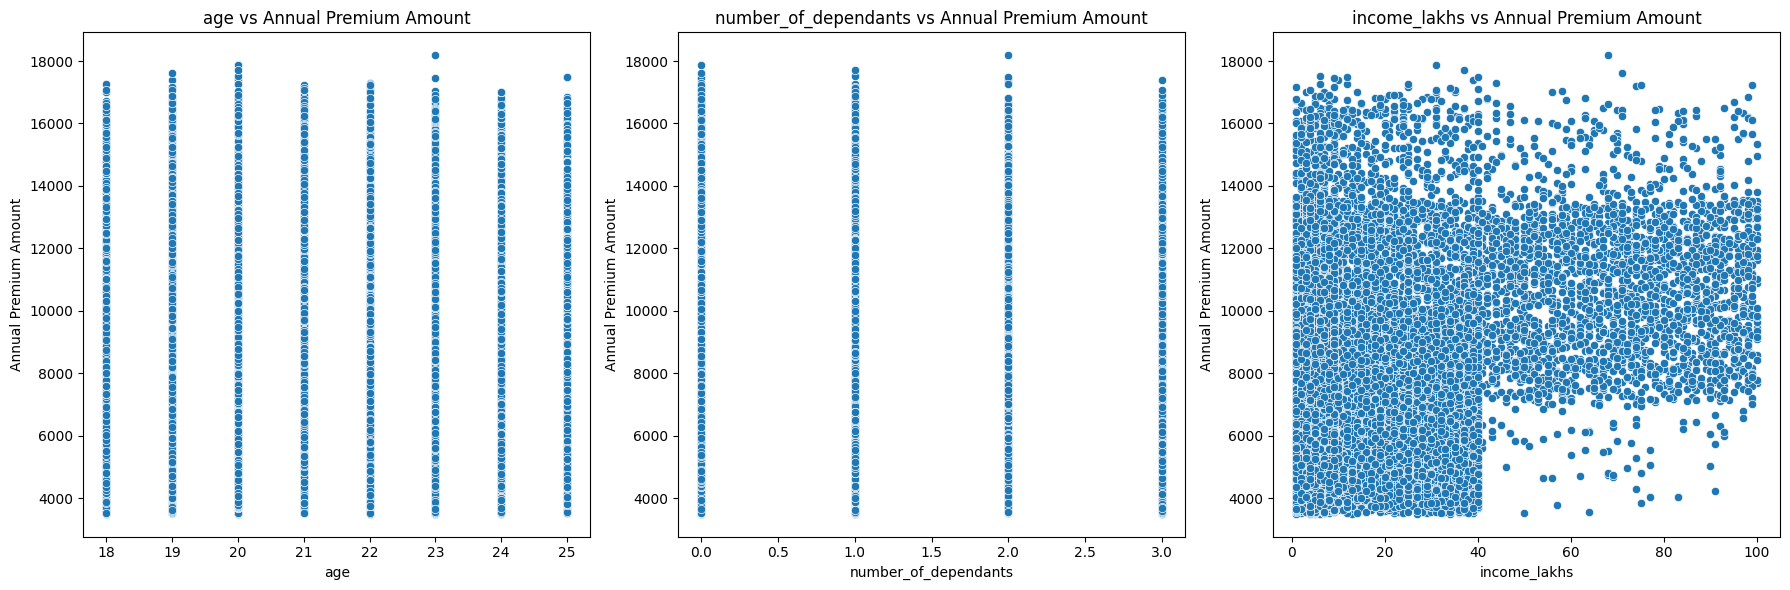

In [101]:
num_feat = ['age', 'number_of_dependants', 'income_lakhs']

fig, axes = plt.subplots(1, len(num_feat), figsize=(18, 6))  # Dynamic size based on column count

for ax, col in zip(axes, num_feat):
    sns.scatterplot(x=df2[col], y=df2['annual_premium_amount'], ax=ax)
    ax.set_title(f'{col} vs Annual Premium Amount')
    ax.set_xlabel(col)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout to prevent overlap 
plt.show()


In [102]:
df2.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount'],
      dtype='object')

In [103]:
cat_feat = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'medical_history', 'insurance_plan', 'income_level']

for col in cat_feat:
    print(col, ':', df2[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']


In [104]:
df2.smoking_status.replace({
    'Smoking=0' : 'No Smoking',
    'Does Not Smoke' : 'No Smoking',
    'Not Smoking': 'No Smoking'
}, inplace=True)
df2.smoking_status.unique()

C:\Users\chara\AppData\Local\Temp\ipykernel_284\2529991949.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2.smoking_status.replace({


array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

<Axes: ylabel='proportion'>

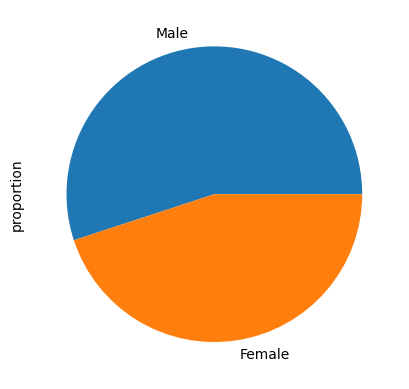

In [105]:
df2.gender.value_counts(normalize=True).plot(kind='pie')

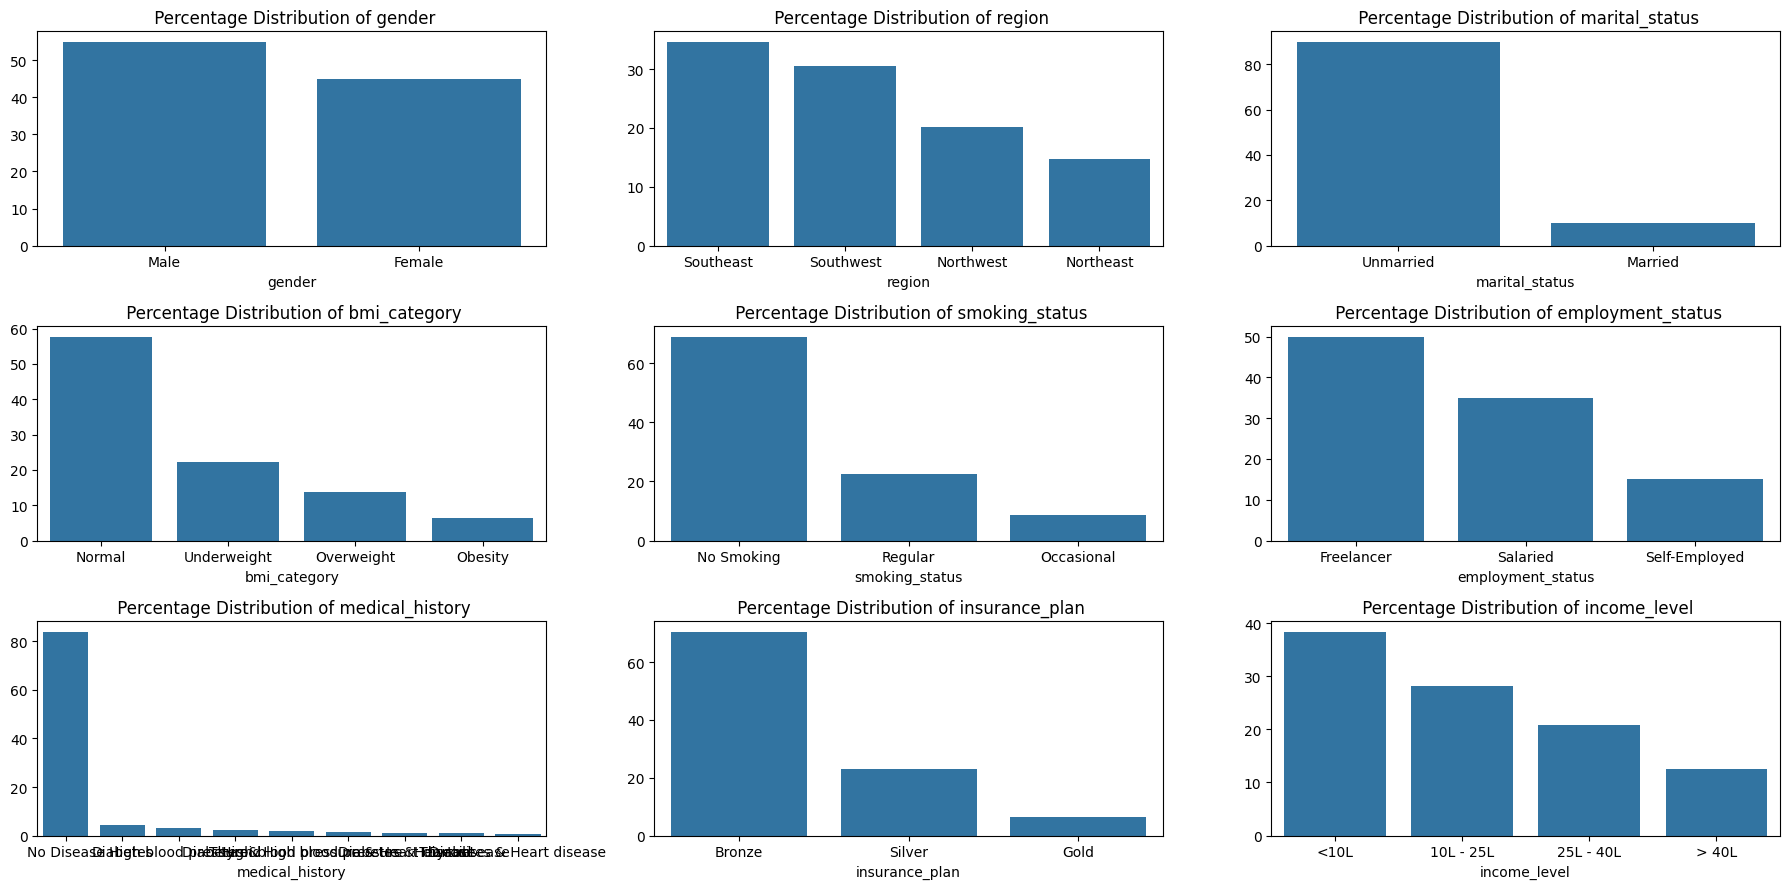

In [106]:
fig, axes = plt.subplots(3, 3, figsize=(18, 9))  # Dynamic size based on column count 
# ax = axes.flatten() 

for ax, col in zip(axes.flatten(), cat_feat): 
    
    pert = df2[col].value_counts(normalize=True)*100 
    sns.barplot(x=pert.index, y=pert.values, ax=ax) 
    ax.set_title(f' Percentage Distribution of {col}')  # Adding title for clarity 
    ax.set_xlabel(col)  

plt.tight_layout()  # Adjust layout to prevent overlap 
plt.show() 

In [110]:
cross_tab = pd.crosstab(df2.income_level, df2.insurance_plan)
cross_tab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,4508,326,828
25L - 40L,3382,209,608
<10L,6172,404,1145
> 40L,115,366,2023


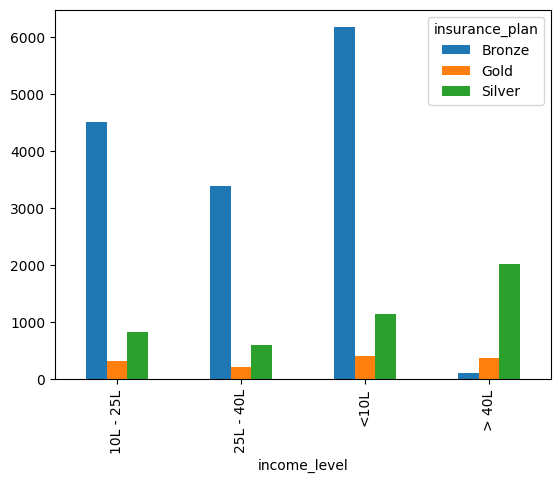

In [35]:
cross_tab.plot(kind='bar')
plt.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

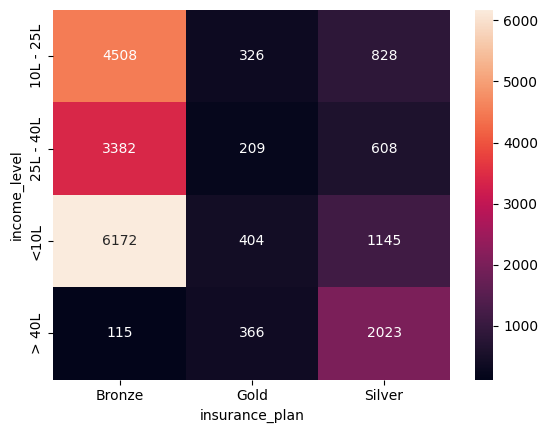

In [36]:
sns.heatmap(cross_tab, annot=True, fmt='d')

# Feature Engineering

In [37]:
# df2.fillna('None', inplace=True)
df.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [38]:
risk_score = {
    'diabetes' : 6,
    'heart disease': 8, 
    'high blood pressure': 6,
    'thyroid' : 5,
    'no disease': 0,
    'none': 0
}


In [39]:
df2[['disease1', 'disease2']] = df2.medical_history.str.split(' & ', expand=True).apply(lambda x: x.str.lower())
df2.sample(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
12526,22,Male,Southwest,Unmarried,1,Underweight,No Smoking,Freelancer,<10L,2,No Disease,Silver,12249,no disease,None
23814,23,Male,Southeast,Unmarried,1,Normal,No Smoking,Salaried,10L - 25L,14,No Disease,Bronze,5195,no disease,None
16667,25,Female,Southeast,Unmarried,0,Underweight,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,8475,no disease,None
1275,18,Male,Northwest,Unmarried,0,Overweight,No Smoking,Freelancer,25L - 40L,30,No Disease,Bronze,5576,no disease,None
23129,18,Male,Southeast,Unmarried,0,Underweight,Regular,Freelancer,> 40L,64,No Disease,Silver,12437,no disease,None


In [40]:
df2['disease1'] = df2['disease1'].fillna('none')
df2['disease2'] = df2['disease2'].fillna('none')

In [41]:
print(df2['disease1'].unique())
print(df2['disease2'].unique())

['high blood pressure' 'no disease' 'diabetes' 'heart disease' 'thyroid']
['none' 'high blood pressure' 'heart disease' 'thyroid']


In [42]:
df2['total_risk_score'] = 0

df2['total_risk_score'] = df2.apply(lambda x: risk_score.get(x['disease1'], 0) + risk_score.get(x['disease2'], 0), axis=1)

max_sc = df2.total_risk_score.max()
min_sc = df2.total_risk_score.min()
df2['normalized_risk_score'] = (df2.total_risk_score-min_sc)/(max_sc - min_sc)

df2.sample(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
28299,22,Female,Southwest,Unmarried,0,Overweight,No Smoking,Freelancer,> 40L,89,No Disease,Silver,10703,no disease,none,0,0.0
45039,20,Female,Southeast,Unmarried,1,Underweight,Regular,Self-Employed,<10L,6,No Disease,Bronze,6347,no disease,none,0,0.0
41664,23,Male,Southeast,Unmarried,0,Underweight,No Smoking,Freelancer,25L - 40L,31,No Disease,Bronze,7739,no disease,none,0,0.0
27479,19,Female,Southwest,Unmarried,1,Normal,No Smoking,Salaried,<10L,6,No Disease,Bronze,5348,no disease,none,0,0.0
13457,21,Male,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,25L - 40L,38,No Disease,Bronze,5575,no disease,none,0,0.0


In [43]:
df2.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
disease1                 0
disease2                 0
total_risk_score         0
normalized_risk_score    0
dtype: int64

In [44]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze':1, 'Silver':2, 'Gold': 3})
df2.insurance_plan.unique()

array([2, 1, 3])

In [45]:
df2['income_level'] = df2['income_level'].map({'<10L': 1, '10L - 25L': 2, '> 40L': 3, '25L - 40L': 4})
df2['income_level'].unique()

array([3, 1, 2, 4])

In [46]:
df2.sample(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
32723,23,Male,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,2,20,No Disease,1,8657,no disease,none,0,0.0
14363,23,Male,Southwest,Unmarried,0,Normal,Occasional,Self-Employed,2,19,No Disease,1,4997,no disease,none,0,0.0
17251,19,Female,Southwest,Married,3,Underweight,No Smoking,Salaried,2,23,No Disease,1,6335,no disease,none,0,0.0
27596,25,Male,Southwest,Unmarried,1,Obesity,Regular,Self-Employed,3,42,No Disease,2,9524,no disease,none,0,0.0
34162,18,Female,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,2,19,No Disease,1,4958,no disease,none,0,0.0


In [47]:
nomial_col = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status' ]

df3 = pd.get_dummies(df2, columns=nomial_col, drop_first=True, dtype=int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
4,18,0,3,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1
9,22,0,1,3,No Disease,2,11050,no disease,none,0,...,0,0,1,0,0,1,0,0,0,0
10,21,0,3,97,No Disease,2,11857,no disease,none,0,...,1,0,1,0,0,0,0,1,1,0
16,25,0,2,15,No Disease,1,5684,no disease,none,0,...,1,0,1,0,0,0,0,0,0,0
19,20,2,2,14,No Disease,1,5712,no disease,none,0,...,1,0,1,0,1,0,0,0,0,0


In [48]:
df4 = df3.drop(columns=['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
4,18,0,3,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
9,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
10,21,0,3,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
16,25,0,2,15,1,5684,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
19,20,2,2,14,1,5712,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


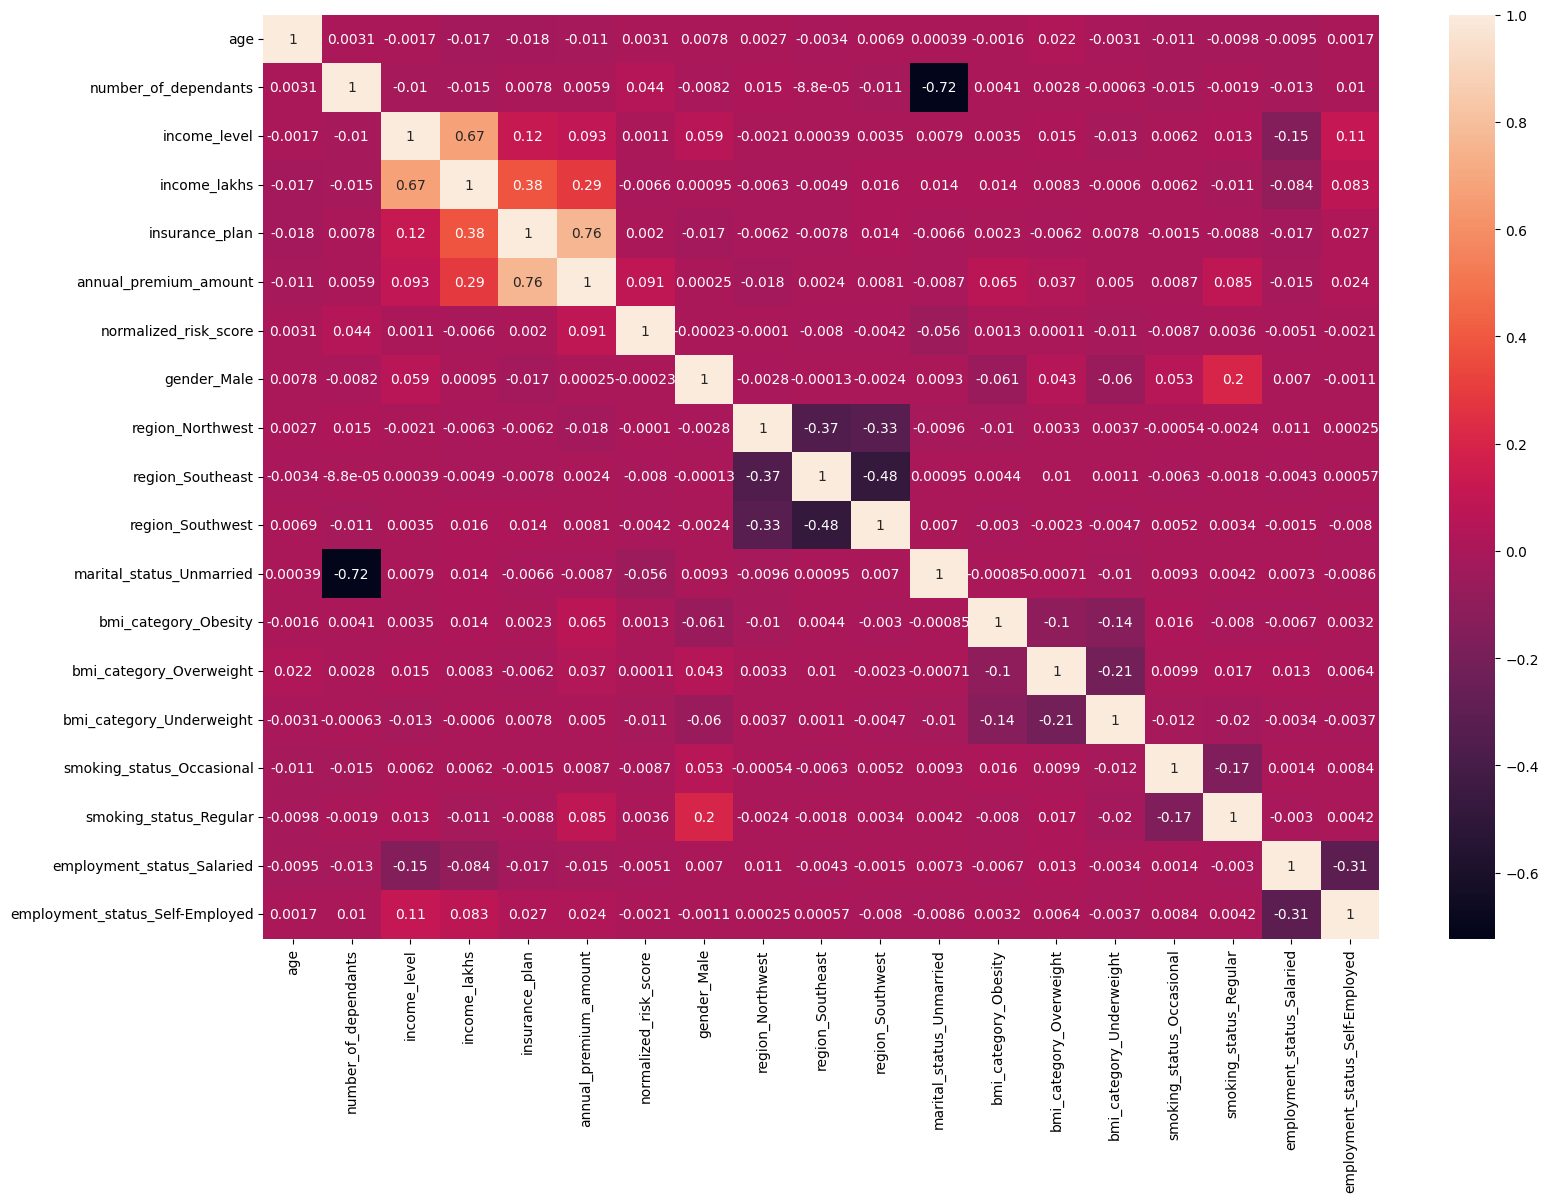

In [49]:
cm = df4.corr()

plt.figure(figsize=(18, 12))
sns.heatmap(cm, annot=True)
plt.show()

MinMaxScaling Cols

In [50]:
X = df4.drop('annual_premium_amount', axis=1)
y = df4['annual_premium_amount']

X.head()


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
4,18,0,3,99,2,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
9,22,0,1,3,2,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
10,21,0,3,97,2,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
16,25,0,2,15,1,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
19,20,2,2,14,1,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


In [51]:
col_scale = ['age', 'number_of_dependants', 'income_lakhs', 'income_level', 'insurance_plan']

scaler = MinMaxScaler()
X[col_scale] = scaler.fit_transform(X[col_scale])

X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.386123,0.216064,0.179578,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.383007,0.219516,0.300051,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif(data):
    vif_df = pd.DataFrame()
    vif_df['column'] = data.columns
    vif_df['vif'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df


In [53]:
vif(X)

,column,vif
0,age,3.144224
1,number_of_dependants,1.867394
2,income_level,3.915844
3,income_lakhs,4.343596
4,insurance_plan,1.647480
5,normalized_risk_score,1.154461
6,gender_Male,2.317166
7,region_Northwest,2.148426
8,region_Southeast,2.971750
9,region_Southwest,2.731418


# Model Training

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10) 

In [55]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((14060, 18), (6026, 18), (14060,), (6026,))

In [56]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
model_lr.score(X_test, y_test)


0.6046339581365334

In [57]:
train_score = model_lr.score(X_train, y_train)
teat_score = model_lr.score(X_test, y_test)

train_score, teat_score

(0.6021300813076781, 0.6046339581365334)

In [58]:
feature_importance = model_lr.coef_

coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['coeff'])
coef_df = coef_df.sort_values(by='coeff', ascending=True)

coef_df

,coeff
number_of_dependants,-144.942755
region_Northwest,-115.033538
income_level,-91.362668
region_Southwest,-68.396359
marital_status_Unmarried,-59.244539
region_Southeast,-37.257673
employment_status_Salaried,-18.766075
employment_status_Self-Employed,-0.579466
gender_Male,13.666084
age,55.570513


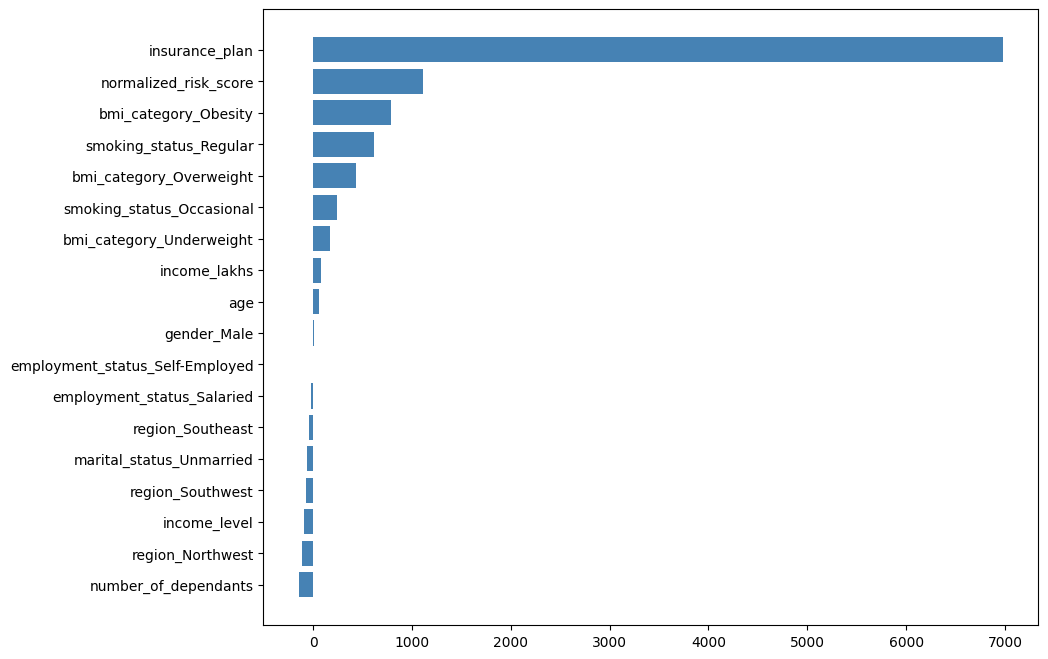

In [59]:
plt.figure(figsize=(10, 8))
plt.barh(coef_df.index, coef_df.coeff, color='steelblue')
plt.show()

In [60]:
from xgboost import XGBRegressor

model_xg = XGBRegressor()
model_xg.fit(X_train, y_train)

train_score = model_xg.score(X_train, y_train)
teat_score = model_xg.score(X_test, y_test)

train_score, teat_score


(0.7257862091064453, 0.5618709921836853)

RandamSearch cross Validation

In [61]:
param_grid = {
    'n_estimator' : [20, 40, 50],
    'learning_rate': [0.01, 0.01, 0.2],
    'max_depth' : [3, 4, 5]
}

random_search = RandomizedSearchCV(model_xg, param_grid, n_iter=10,  cv=5, scoring='r2', random_state=42)
random_search.fit(X_train, y_train)
random_search.best_score_

c:\ProgramData\anaconda3\envs\py-latest\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:07:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\ProgramData\anaconda3\envs\py-latest\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:07:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\ProgramData\anaconda3\envs\py-latest\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:07:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\ProgramData\anaconda3\envs\py-latest\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:07:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimato

np.float64(0.5902175426483154)

In [62]:
random_search.best_params_

{'n_estimator': 20, 'max_depth': 4, 'learning_rate': 0.2}

In [63]:
best_model = random_search.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimator=20,
             n_estimators=None, n_jobs=None, ...)

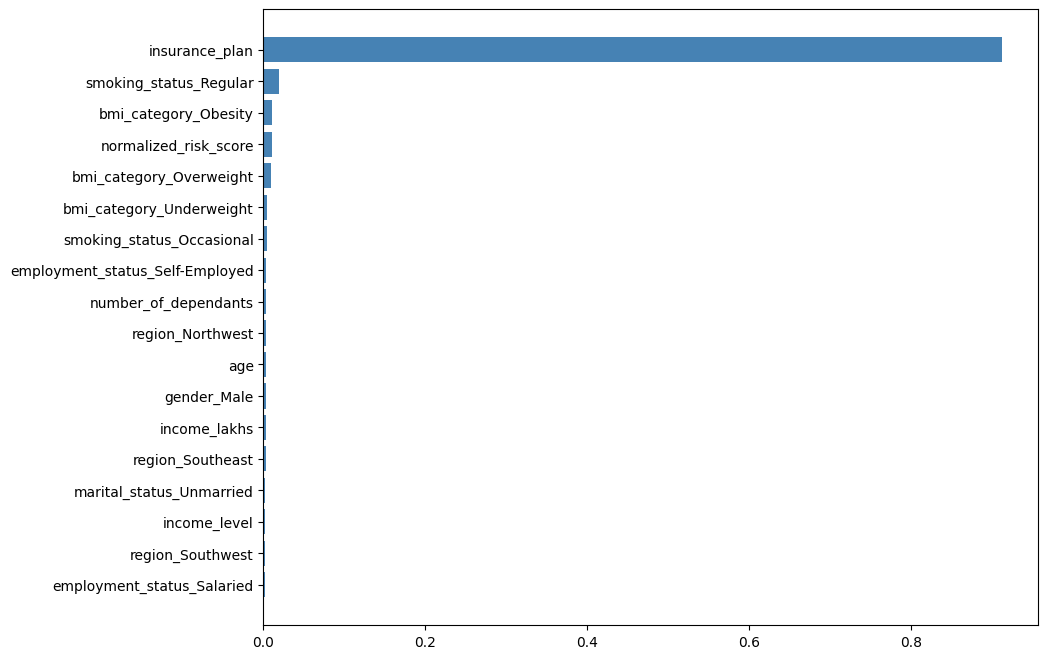

In [64]:
feature_importance = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['coeff'])
coef_df = coef_df.sort_values(by='coeff', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(coef_df.index, coef_df.coeff, color='steelblue')
plt.show()

# Error analysis

In [65]:
y_pred = best_model.predict(X_test)

resd  = y_pred-y_test
resd_per = resd*100/y_test

results_df = pd.DataFrame({
    'acutal': y_test,
    'predicted': y_pred,
    'dif': resd,
    'diff_pct': resd_per

})

results_df.head()


,acutal,predicted,dif,diff_pct
31773,6238,6560.653809,322.653809,5.172392
36669,9462,7126.395996,-2335.604004,-24.684041
32856,5152,6675.370117,1523.370117,29.568519
35465,6988,8155.290527,1167.290527,16.704215
48220,4917,6614.551758,1697.551758,34.524136


<Axes: xlabel='diff_pct', ylabel='Count'>

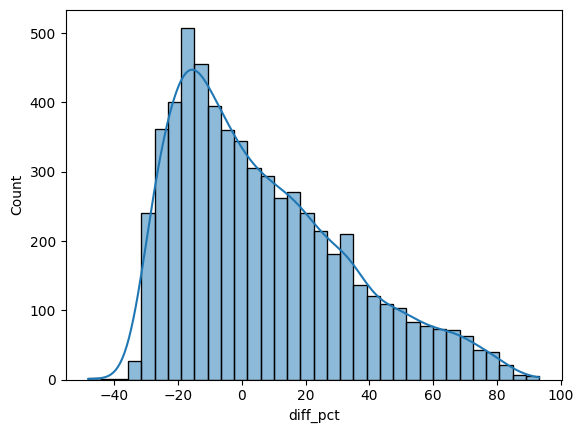

In [66]:
sns.histplot(results_df.diff_pct, kde=True)

In [67]:
error_threshold = 10

error_pred = results_df[abs(results_df.diff_pct)>error_threshold]
error_pred.shape

(4389, 4)

In [68]:
error_pred.shape[0]*100/results_df.shape[0]

72.83438433455028

In [69]:
results_df[abs(results_df.diff_pct)>50].sort_values(by='diff_pct', ascending=False)


,acutal,predicted,dif,diff_pct
25685,3784,7310.918457,3526.918457,93.206090
42510,3562,6798.109863,3236.109863,90.850923
36729,3549,6758.064453,3209.064453,90.421653
42807,3629,6902.163086,3273.163086,90.194629
46406,3616,6869.232910,3253.232910,89.967724
...,...,...,...,...
19469,4999,7503.407227,2504.407227,50.098164
17105,4264,6398.926270,2134.926270,50.068627
12866,4936,7406.691895,2470.691895,50.054536
47621,4892,7340.140625,2448.140625,50.043758


In [70]:
error_df = X_test.loc[error_pred.index]
error_df

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
36669,0.285714,0.000000,0.000000,0.060606,0.0,0.000000,0,0,0,1,1,0,0,0,0,1,0,1
32856,0.714286,0.333333,0.333333,0.141414,0.0,0.000000,1,1,0,0,1,0,0,0,0,1,0,1
35465,0.714286,0.333333,0.333333,0.222222,0.0,0.000000,1,0,1,0,1,1,0,0,0,1,0,0
48220,0.571429,0.000000,0.333333,0.101010,0.0,0.000000,1,0,0,1,1,0,0,1,0,0,0,0
26379,0.428571,0.333333,0.000000,0.050505,0.0,0.357143,0,0,1,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,0.142857,0.666667,0.333333,0.111111,0.0,0.785714,0,0,0,1,1,0,0,1,0,0,1,0
44016,0.571429,0.000000,1.000000,0.343434,0.0,0.000000,1,0,0,0,1,0,0,0,0,0,1,0
14333,0.857143,0.333333,0.000000,0.040404,0.0,0.000000,1,1,0,0,1,0,0,0,0,1,0,0
25524,0.000000,0.000000,0.333333,0.111111,0.5,0.000000,1,0,1,0,1,0,1,0,0,1,1,0


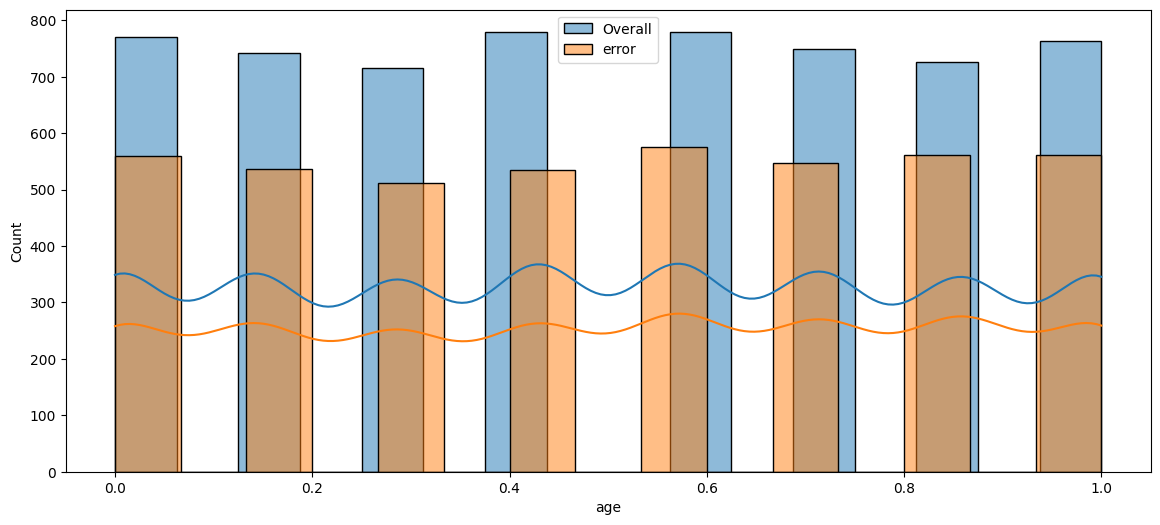

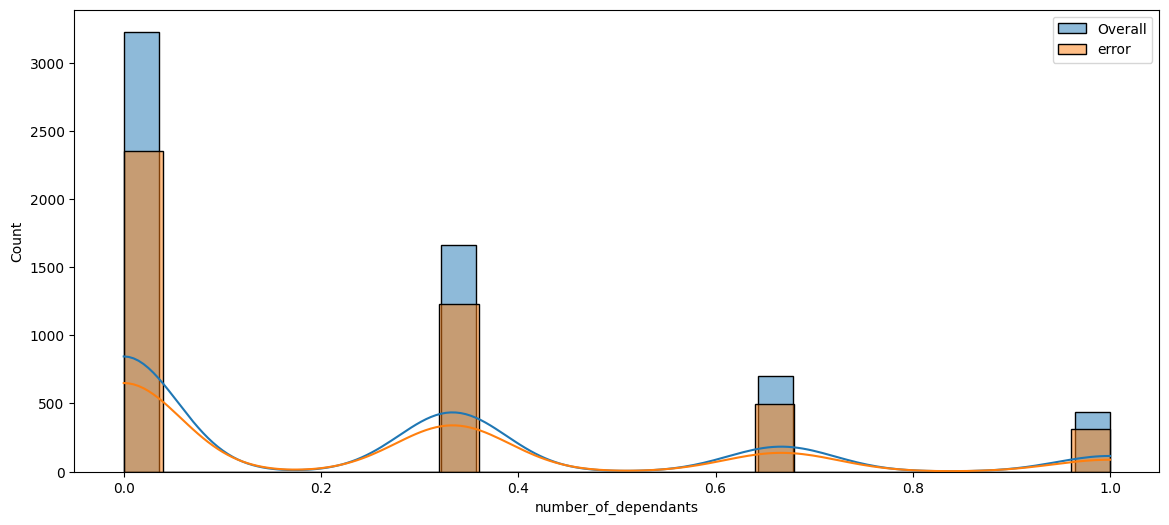

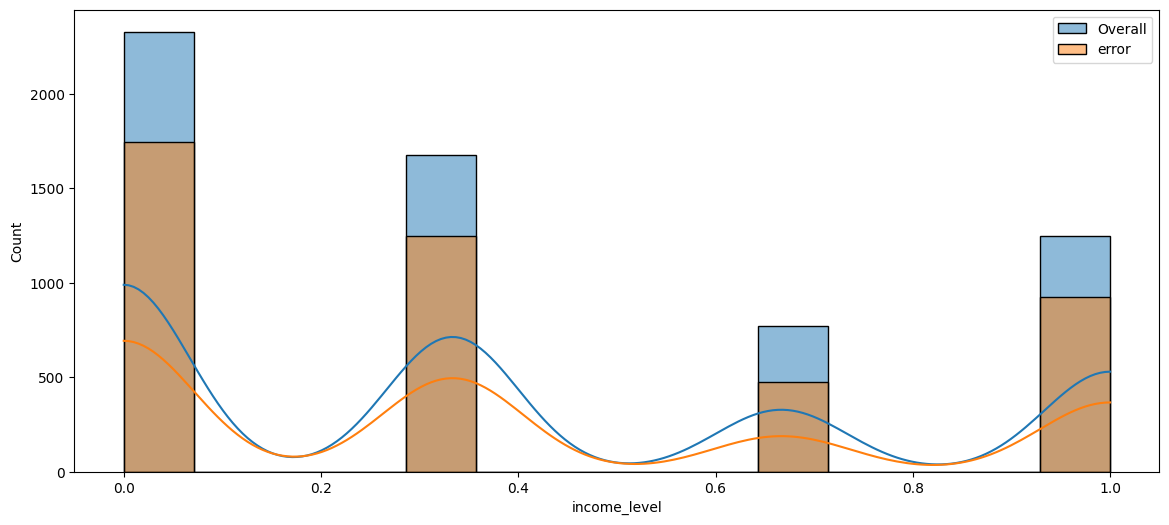

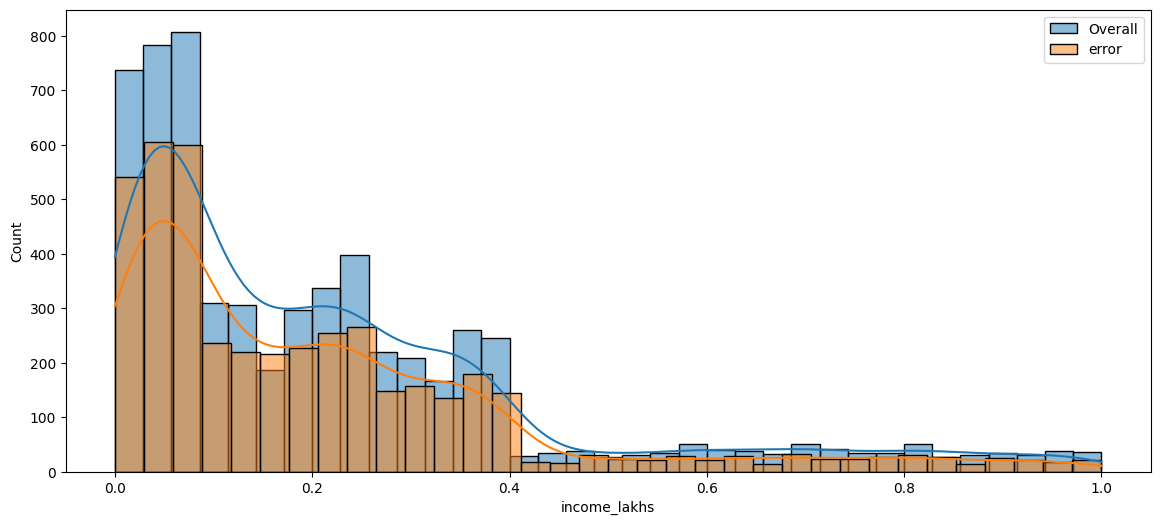

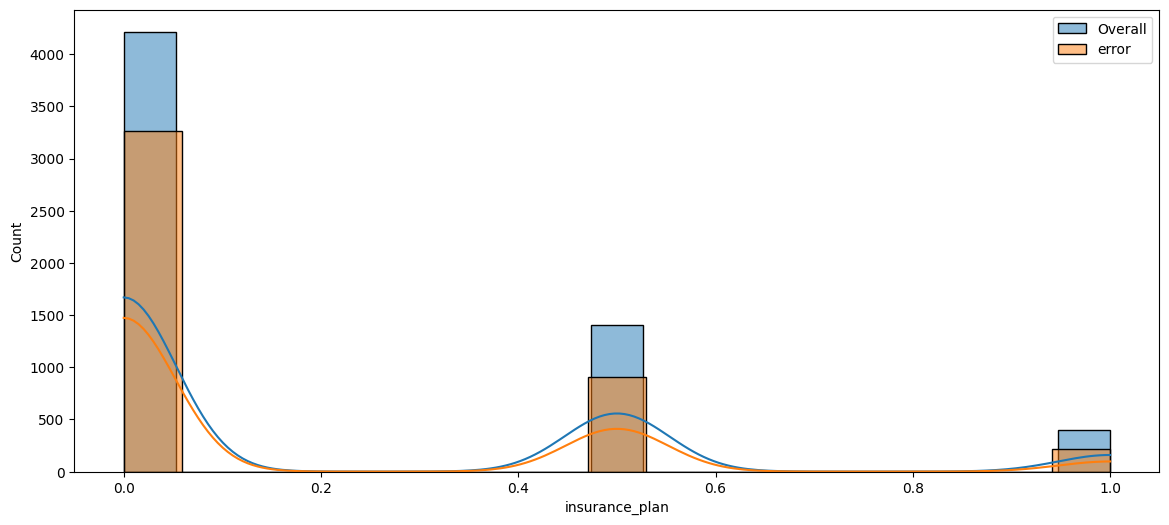

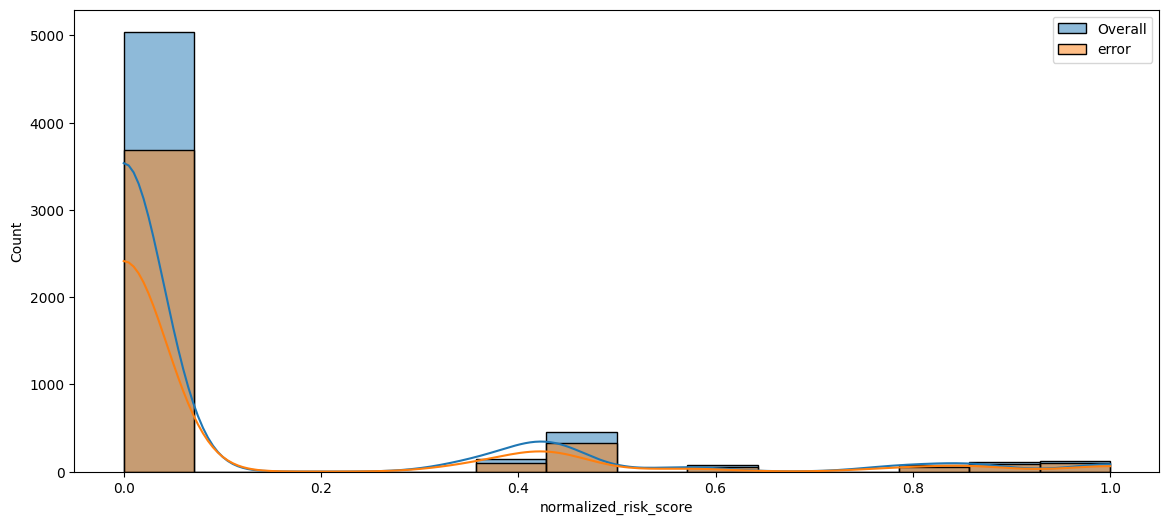

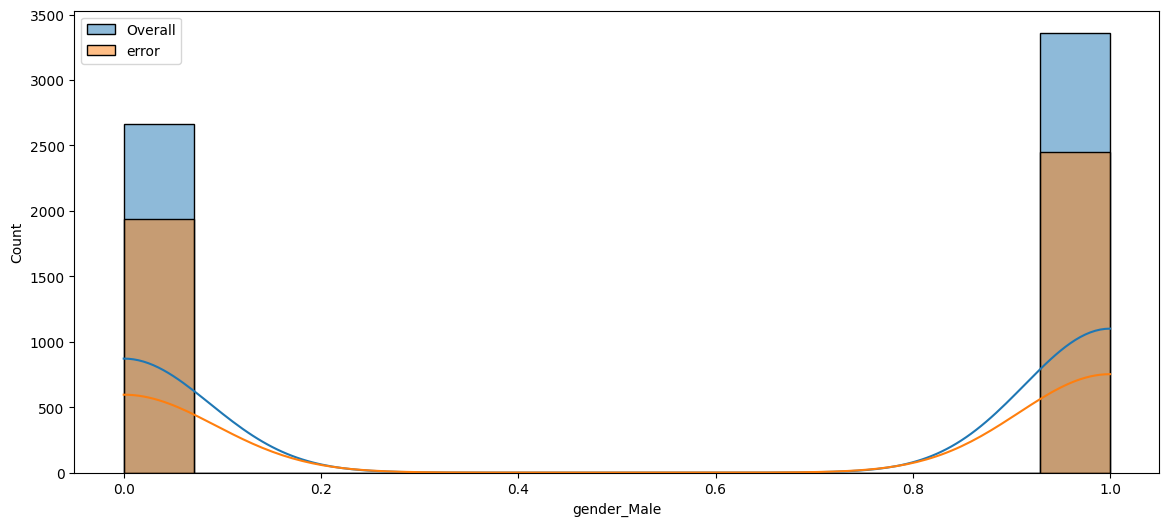

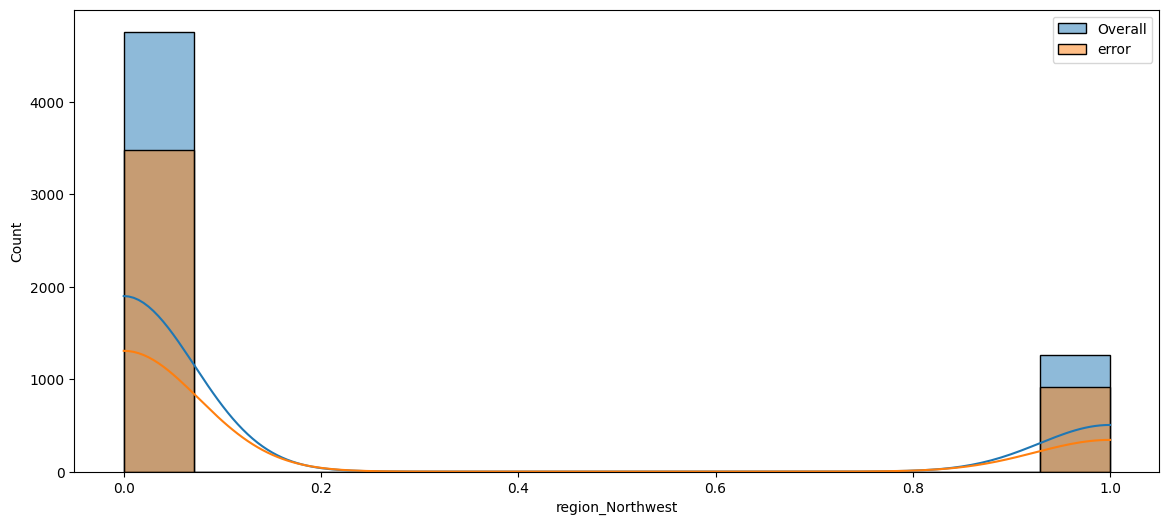

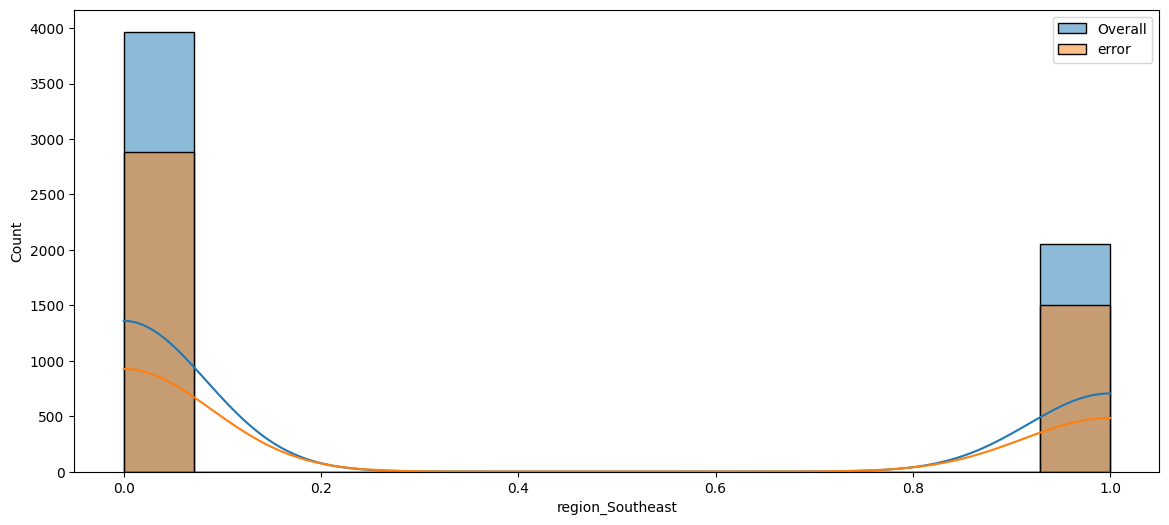

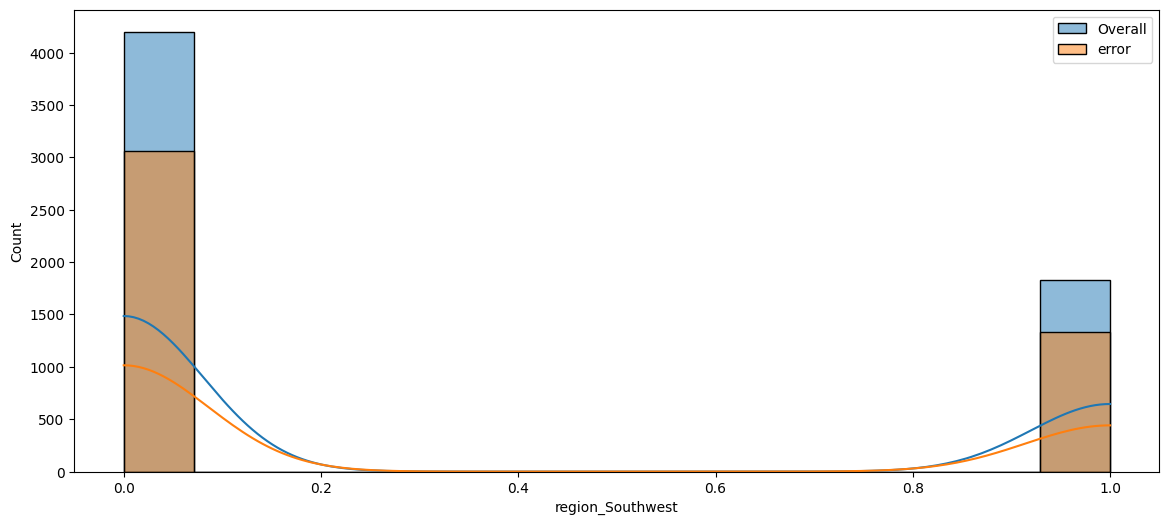

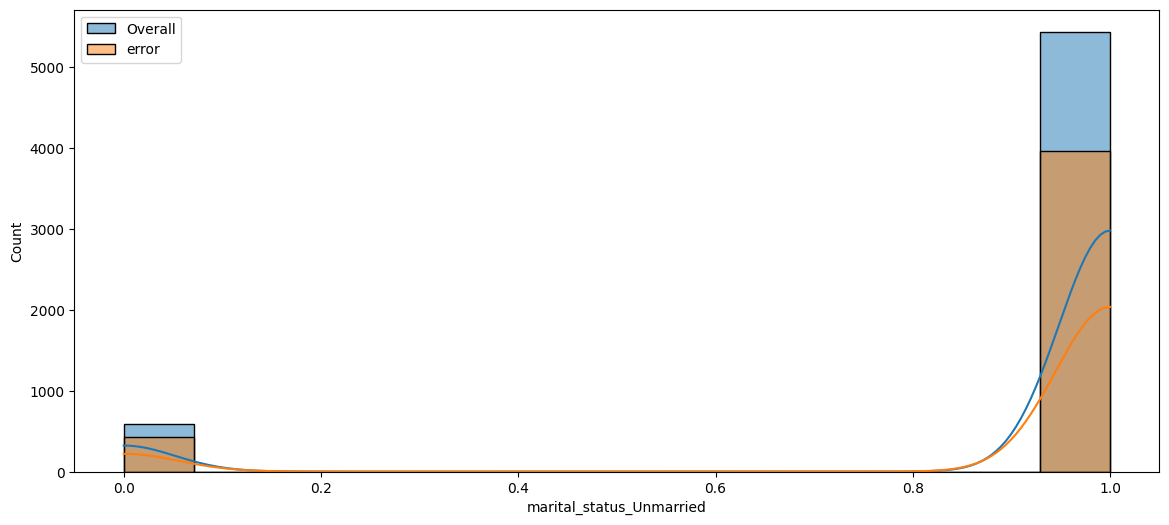

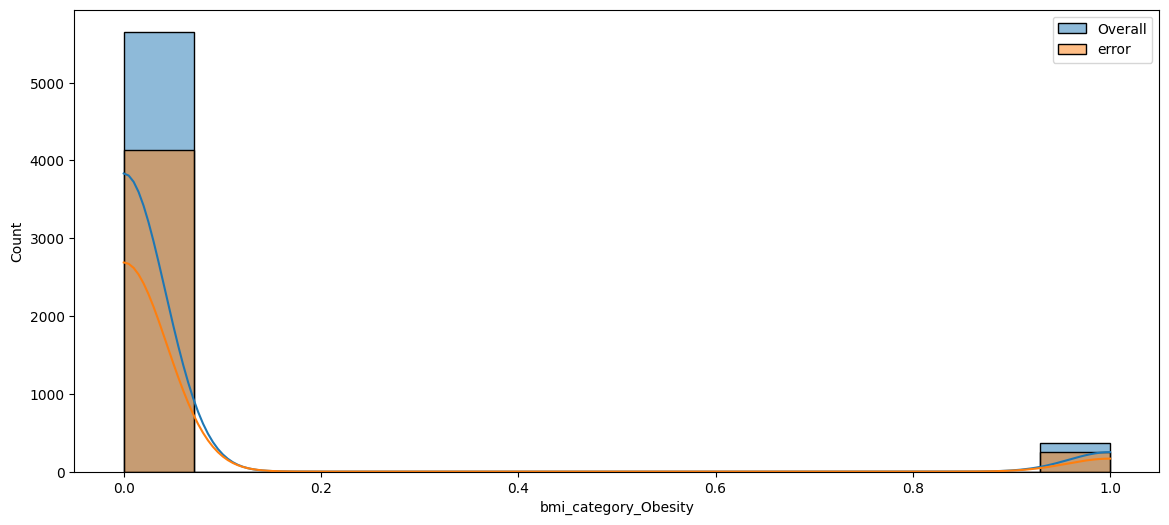

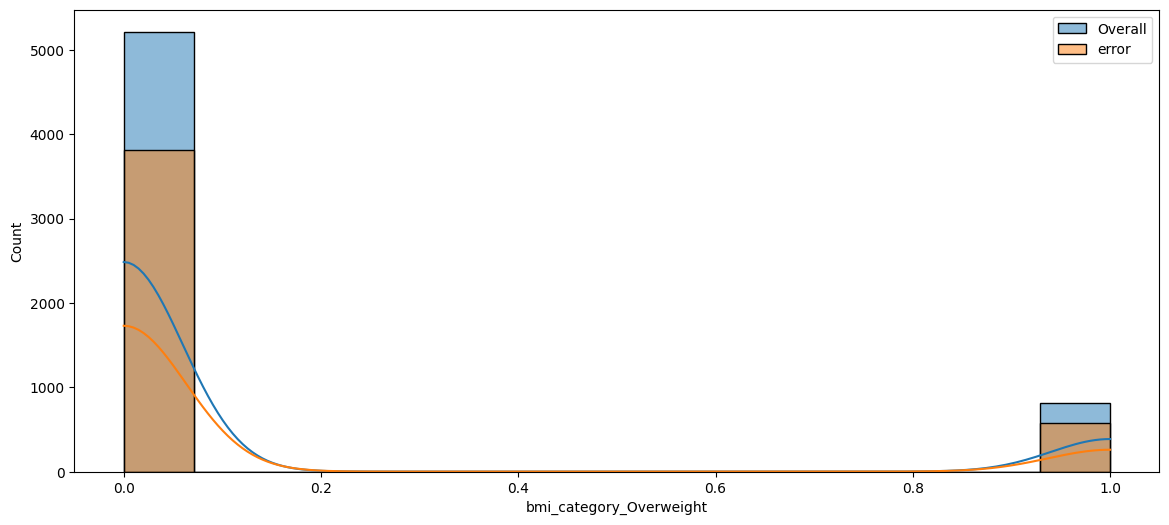

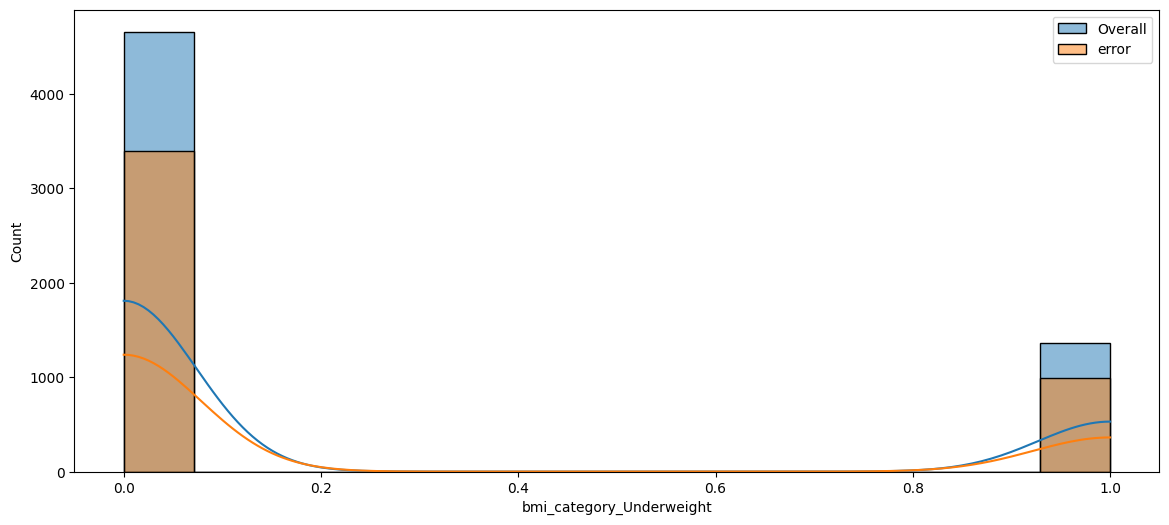

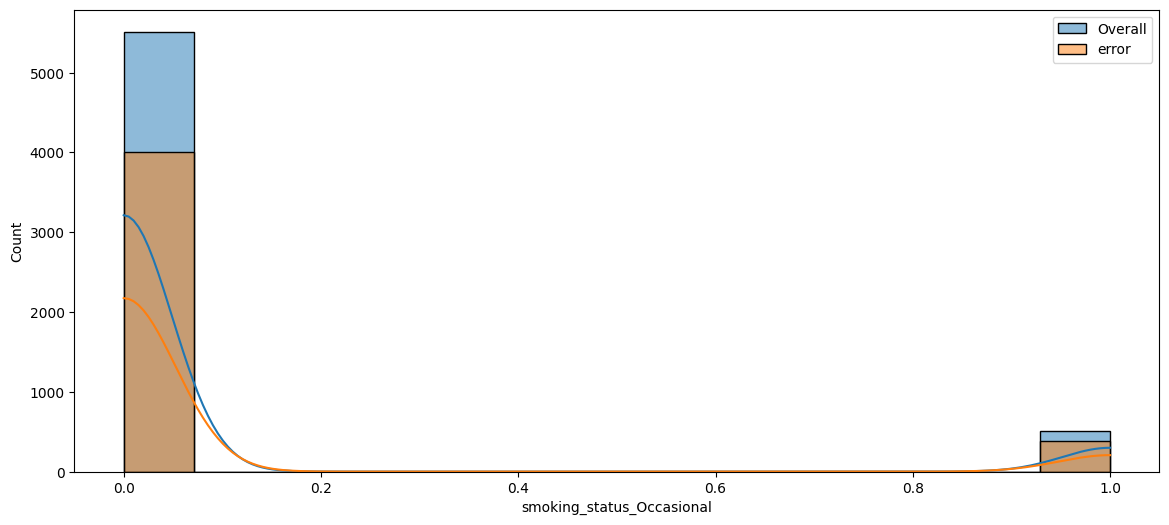

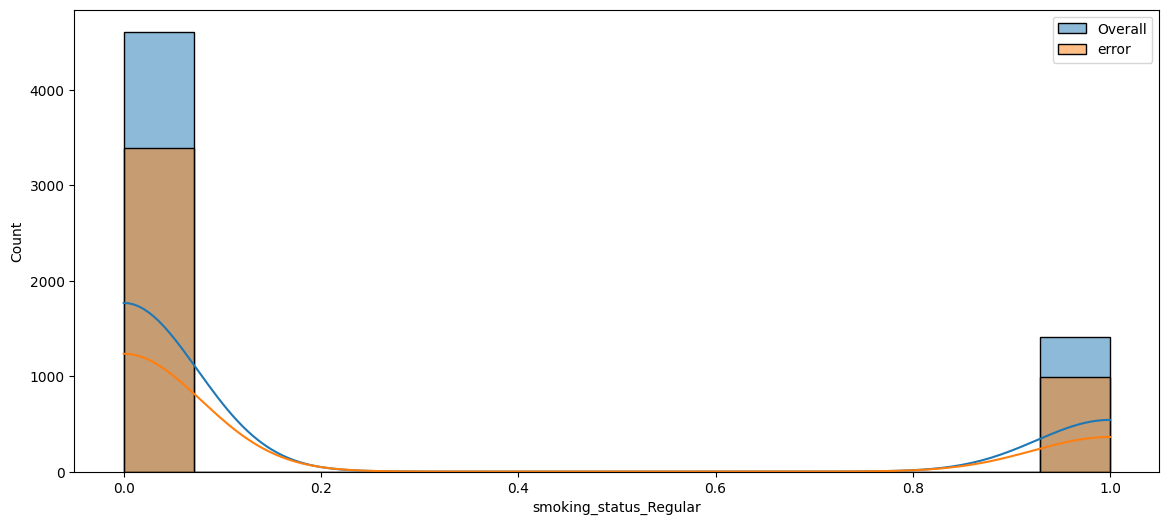

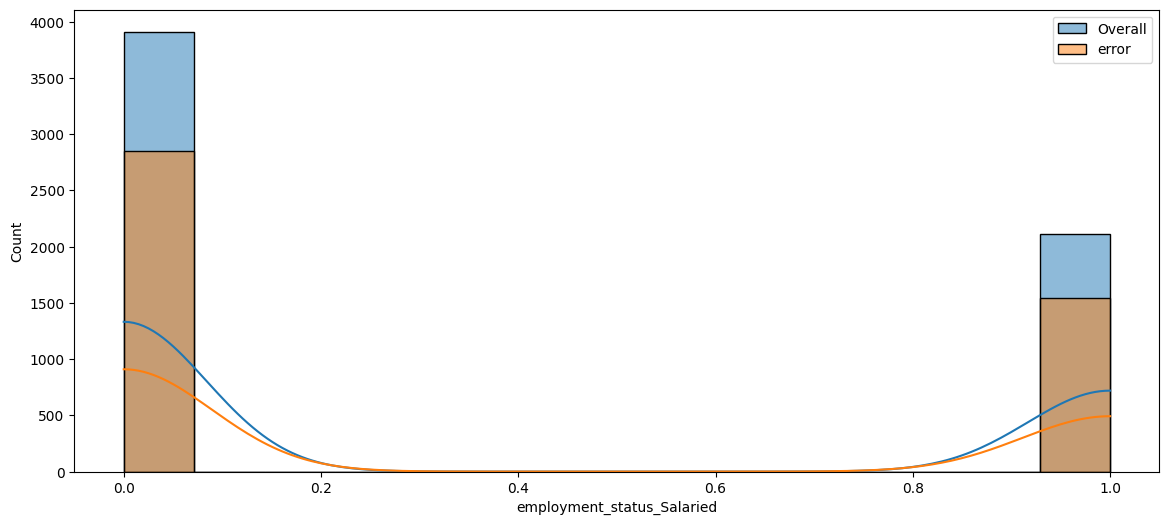

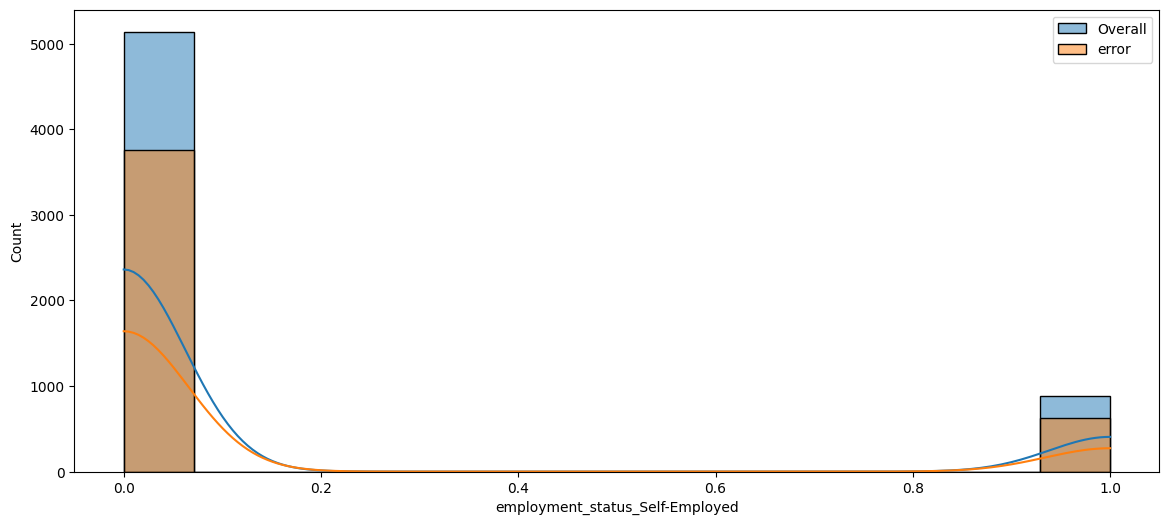

In [71]:
for col in X_test.columns:
    plt.figure(figsize=(14, 6))
    sns.histplot(X_test[col], kde=True, label='Overall')
    sns.histplot(error_df[col], kde=True, label='error')
    plt.legend()
    plt.show()

we can observe some insighs in age Distribution

In [72]:

df_unscale = pd.DataFrame()

df_unscale[col_scale] = scaler.inverse_transform(error_df[col_scale])
df_unscale

,age,number_of_dependants,income_lakhs,income_level,insurance_plan
0,20.0,0.0,7.0,1.0,1.0
1,23.0,1.0,15.0,2.0,1.0
2,23.0,1.0,23.0,2.0,1.0
3,22.0,0.0,11.0,2.0,1.0
4,21.0,1.0,6.0,1.0,1.0
...,...,...,...,...,...
4384,19.0,2.0,12.0,2.0,1.0
4385,22.0,0.0,35.0,4.0,1.0
4386,24.0,1.0,5.0,1.0,1.0
4387,18.0,0.0,12.0,2.0,2.0


<Axes: xlabel='age', ylabel='Count'>

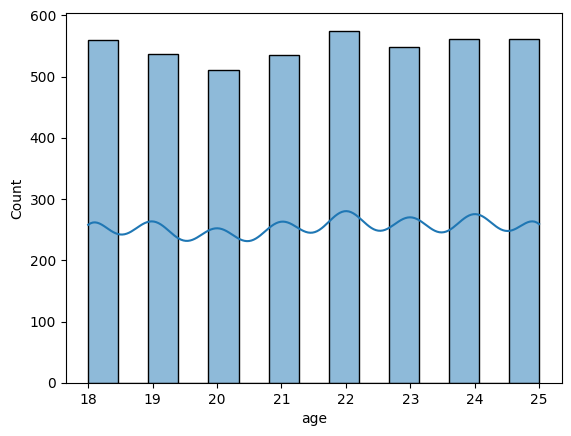

In [73]:
sns.histplot(df_unscale.age, kde=True)

In [74]:
df_unscale.age.quantile(0.999)

np.float64(25.0)